In [1]:
!pip install scikit-image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from skimage.io import imread_collection

#path to training images
train_n = 'chest_xray/train/NORMAL/*.jpeg'
train_p = 'chest_xray/train/PNEUMONIA/*.jpeg'

#creating a collection with the available images
normal = imread_collection(train_n)
pneumonia = imread_collection(train_p)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Not uninstalling scipy at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'scipy'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
#not so efficient way of getting the histogram over a collection
def histo(collection, bins=1000):
    n = collection[0]
    n = ((n - np.amin(n))/(np.amax(n) - np.amin(n))).flatten()
    for img in collection[1:]:
        #import images
        img = img
        #normalize images
        mn = np.amin(img)
        mx = np.amax(img)
        img = ((img - mn)/(mx - mn)).flatten()
        np.concatenate((n, img))
    #compare histograms
    mn = np.amin(img)
    mx = np.amax(img)
    histo = np.histogram(img, bins=np.arange(mn, mx + (mx-mn)/bins, (mx-mn)/bins))
    return histo

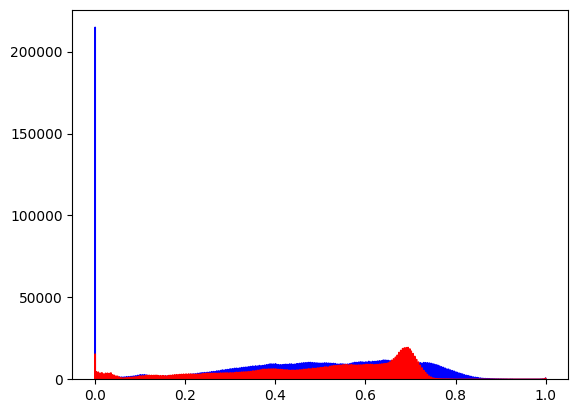

In [3]:
#show differences in pixel intensity for healthy vs sick
histo_n_c, histo_n_b = histo(normal)
histo_p_c, histo_p_b = histo(pneumonia)
plt.stairs(histo_n_c, histo_n_b, color='blue')
plt.stairs(histo_p_c, histo_p_b, color='red')
plt.show()
plt.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 num_classes=2):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.train_len = len(self.df)
        self.num_classes = num_classes

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        return math.ceil(self.train_len/self.batch_size)   
     
    def __data_augmentation(self, img):
        img = tf.image.random_flip_left_right(img)
        return img
    
    def __get_image(self, file_id):
        image = tf.keras.preprocessing.image.load_img(file_id)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = self.__data_augmentation(image_arr)
        #print(np.amin(image_arr), np.amax(image_arr))
        #plt.imshow(image_arr/255.)
        #plt.show()
        #plt.close()
        x,y,_ = self.input_size

        if image_arr.shape[0] > image_arr.shape[1]:
            image_arr = tf.image.resize(image_arr, (int(y*image_arr.shape[0]/image_arr.shape[1]), y))
            offset_width = 0
            offset_height = int((image_arr.shape[0]-y)/2)
        else:
            image_arr = tf.image.resize(image_arr, (x, int(x*image_arr.shape[1]/image_arr.shape[0])))

            offset_width = int((image_arr.shape[1]-x)/2)
            offset_height = 0

        image_arr = tf.image.crop_to_bounding_box(image_arr,offset_width=offset_width, offset_height=offset_height, target_width=x, target_height=y).numpy()
        image_arr = (image_arr - np.amin(image_arr))/(np.amax(image_arr)-np.amin(image_arr))
        #plt.imshow(image_arr)
        #plt.show()
        #plt.close()
        #print(np.amin(image_arr), np.amax(image_arr))
        return image_arr
    
    def __get_label(self, label_id):
        #label_id = tf.keras.utils.to_categorical(label_id, self.num_classes)
        return label_id
    
    def __getitem__(self, idx):
        batch_x = self.df["filenames"][idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.df["labels"][idx * self.batch_size:(idx + 1) * self.batch_size]
        x = [self.__get_image(file_id) for file_id in batch_x] 
        y = [self.__get_label(label_id) for label_id in batch_y]

        return tf.convert_to_tensor(x), tf.convert_to_tensor(y)

2023-03-18 11:59:36.019787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 11:59:36.264428: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 11:59:36.274099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-18 11:59:36.274142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
def data_to_df(data_dir):
    df = pd.DataFrame()
    filenames = []
    labels = []
    
    for dataset in os.listdir(data_dir):
        if dataset == 'PNEUMONIA':
            img_list = os.listdir(os.path.join(data_dir, dataset))
            for image in img_list[0:300]:
                filenames.append(os.path.join(data_dir, dataset, image))
                labels.append(1)
        else:
            img_list = os.listdir(os.path.join(data_dir, dataset))
            for image in img_list[0:200]:
                filenames.append(os.path.join(data_dir, dataset, image))
                labels.append(0)
    df["filenames"] = filenames
    df["labels"] = labels
        
    return df

In [4]:
train_df = data_to_df('chest_xray/train')

val_df = data_to_df('chest_xray/val')

test_df = data_to_df('chest_xray/test')

input_size = (224,224,3)

train_set = CustomDataGen(train_df,
                         batch_size=16, input_size=input_size)

val_set = CustomDataGen(val_df,
                         batch_size=16, input_size=input_size)

test_set = CustomDataGen(test_df,
                         batch_size=200, input_size=input_size)

2023-03-18 11:59:39.694490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-18 11:59:39.694528: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 11:59:39.694555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8e4db396-18e9-4489-b011-ba508fea49e1): /proc/driver/nvidia/version does not exist
2023-03-18 11:59:39.694937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
tf.Tensor(0, shape=(), dtype=int32)


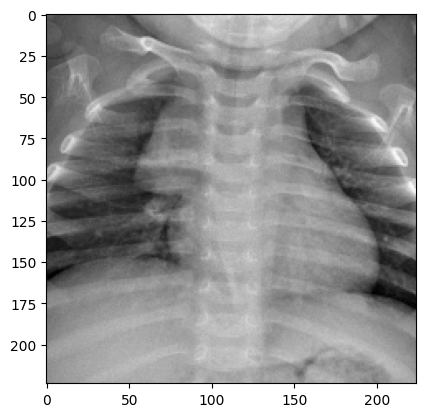

In [5]:
x,y = train_set.__getitem__(0)
image = x[0]
print(y[0])
plt.imshow(image)
plt.show()


In [6]:
def train_model():
    inputs = keras.Input(shape=input_size)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    '''x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)'''
    x = layers.Flatten()(x)
    '''x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)'''
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
model = train_model()
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.0001,
                                                    decay_steps=100000,
                                                    decay_rate=0.96,
                                                    staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="binary_crossentropy", metrics="accuracy")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                           

In [14]:
w = len(normal)/(len(normal) + len(pneumonia))
class_weights = {0:1-w, 1:w}
history = model.fit(train_set,
                    epochs=1,
                    validation_data=val_set,
                    class_weight=class_weights)

28/28 [==============================] - 62s 2s/step - loss: 0.1635 - accuracy: 0.7880 - val_loss: 0.9294 - val_accuracy: 0.5000


1/1 [==============================] - 6s 6s/step
average accuracy 0.6280654120829798


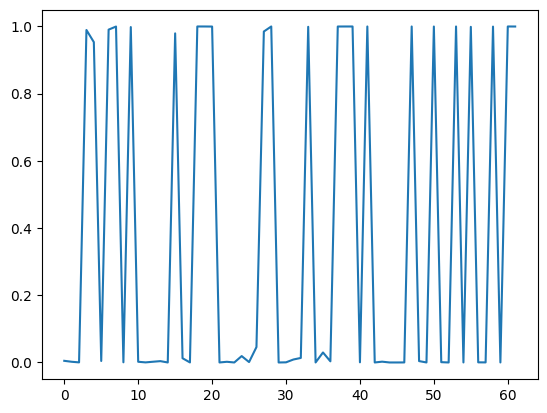

In [12]:
pred = model.predict(test_set)
x,y = test_set.__getitem__(0)
pred = np.reshape(pred, pred.shape[0])
result = abs(pred-y.numpy().astype(float))
print('average accuracy', 1-np.mean(result))
plt.plot(result)
plt.show()
plt.close()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e4db396-18e9-4489-b011-ba508fea49e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>